# `Cartopy` 地图绘制（3）
![](https://scitools.org.uk/cartopy/docs/latest/_static/cartopy.png)

**Carto**graphy **Py**thon

------------------------

主讲人：李显祥

大气科学学院

## 地图背景 - 天地图

- 天地图（和其它很多种地图服务）都采用 Web Map Tile Service (WMTS) 来提供地图服务。 
- 常用的有 Google，OpenStreetMap等
- 国内有百度、高德等

由于它们都遵循相同的规范，我们可以通过修改 `cartopy` 中已有的 Google 地图类来实现天地图的调用。

In [1]:
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

headers='Mozilla/5.0' #{'User-Agent': 'Mozilla/5.0'}
tk = <your-token>

class TDT(cimgt.GoogleWTS):
    def __init__(self, desired_tile_form='RGB', cache=False):
        super().__init__(desired_tile_form=desired_tile_form,
                         user_agent = headers)
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://t0.tianditu.gov.cn/DataServer?T=vec_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        return url
    
class TDT_ter(cimgt.GoogleWTS):
    def __init__(self, desired_tile_form='RGB', cache=False):
        super().__init__(desired_tile_form=desired_tile_form,
                         user_agent = headers)
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://t0.tianditu.gov.cn/DataServer?T=ter_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        return url
    
class TDT_img(cimgt.GoogleWTS):
    def __init__(self, desired_tile_form='RGB', cache=False):
        super().__init__(desired_tile_form=desired_tile_form,
                         user_agent = headers)
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://t0.tianditu.gov.cn/DataServer?T=img_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        return url

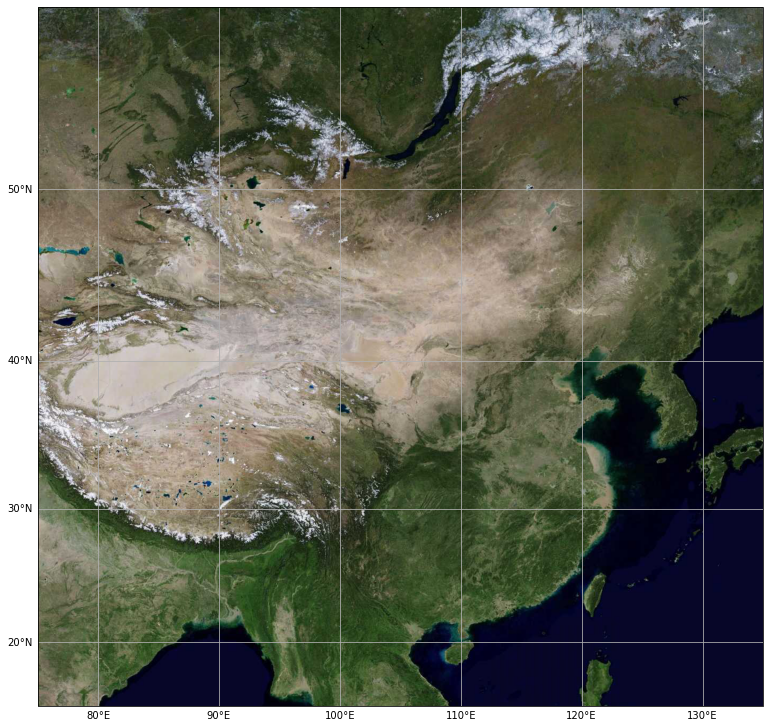

In [2]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

extent = [75, 135, 15, 55] #21.5, 23.5] #广东图
#request = TDT() #矢量图层
request = TDT_img() #影像
#request = TDT_ter() #地形
fig, ax = make_map(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request, 5)# leve  l=10 缩放等级 

## 绘制台风路线动画

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader
import pandas as pd

%matplotlib inline

In [4]:
def make_plot(WTS,level):
    extent = [72, 135, 15, 54]
    shp= '../shp_file/china.shp'
    proj = ccrs.PlateCarree()
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=WTS.crs))
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.set_extent(extent)
    ax.add_image(WTS, level) 
    reader = Reader(shp)
    provinces = cfeat.ShapelyFeature(reader.geometries(),proj, edgecolor='white', facecolor='none')
    ax.add_feature(provinces, edgecolor='w',linewidth=1) 
    sub_extent = [105, 125, 0, 25]
    sub_ax = fig.add_axes([0.66, 0.13, 0.135, 0.155], projection=WTS.crs)
    sub_ax.set_extent(sub_extent)
    sub_ax.add_image(WTS, level) 
    sub_ax.add_feature(provinces, edgecolor='w',linewidth=1)
    return fig,ax,sub_ax

In [5]:
typhoon = pd.read_csv("1909.csv")
typhoon.dropna(subset=['wind'],inplace=True)
typhoon = typhoon.reset_index()
typhoon['class'] = ''
typhoon.loc[(typhoon['wind']>=10.8) & (typhoon['wind']<=17.1),'class'] = 'TROPICAL DEPRESSION'
typhoon.loc[(typhoon['wind']>17.2) & (typhoon['wind']<=24.4),'class'] = 'TROPICAL STORM'
typhoon.loc[(typhoon['wind']>24.5) & (typhoon['wind']<=32.6),'class'] = "SEVERE TROPICAL STORM"
typhoon.loc[(typhoon['wind']>32.7) & (typhoon['wind']<=41.4),'class'] = "TYPHOON"
typhoon.loc[(typhoon['wind']>41.5) & (typhoon['wind']<=50.9),'class'] = "SEVERE TYPHOON"
typhoon.loc[(typhoon['wind']>51),'class']="SUPER TYPHOON"
#color_dict = {'TROPICAL DEPRESSION': '#7fffd4', 'TROPICAL STORM': '#008000', "SEVERE TROPICAL STORM": '#0000ff', 
#              "TYPHOON": '#ffff00', "SEVERE TYPHOON": '#ffa500', "SUPER TYPHOON": '#ff4500'}
color_dict = {'TROPICAL DEPRESSION': 'lime', 'TROPICAL STORM': 'blue', "SEVERE TROPICAL STORM": 'yellow', 
              "TYPHOON": 'orange', "SEVERE TYPHOON": 'red', "SUPER TYPHOON": 'darkred'}

MovieWriter ffmpeg unavailable; using Pillow instead.


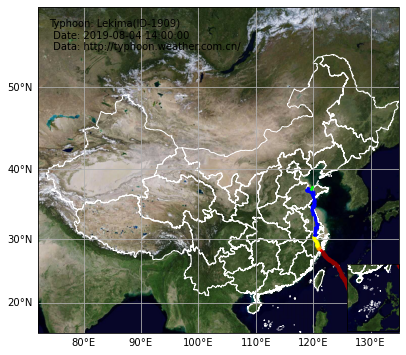

In [23]:
import matplotlib.animation as animation
wts = TDT_img()  
fig,ax,sub_ax = make_plot(wts,5)

dots, = ax.plot([], [], linewidth=2.5, transform=ccrs.PlateCarree())
line  = ax.scatter(None,None, s=10, alpha=0.8, transform=ccrs.PlateCarree())
sub_dots, =  sub_ax.plot([], [], linewidth=2.5,transform=ccrs.Geodetic())
sub_line  =  sub_ax.scatter(None, None, s=10, alpha=0.8, transform=ccrs.PlateCarree())

ax.annotate('Typhoon: %s\n Date: %s\n Data: http://typhoon.weather.com.cn/\n' % ('Lekima(ID-1909)', "2019-08-04 14:00:00"),
            xy=(0, 1), xytext=(12, -12), va='top', ha='left',xycoords='axes fraction', textcoords='offset points')

def animate(i):
        a0, b0 = typhoon.at[i,"lon"], typhoon.at[i,"lat"]
        a1, b1 = typhoon.at[i+1,"lon"], typhoon.at[i+1,"lat"]
            
        dots, = ax.plot((a0,a1),(b0,b1), linewidth=2.5,color=color_dict[typhoon.at[i+1,"class"]], 
                transform=ccrs.PlateCarree())
        line = ax.scatter(a0, b0, s=10, c=color_dict[typhoon.at[i,"class"]], alpha=0.8, 
                   transform=ccrs.PlateCarree())
        sub_dots, = sub_ax.plot((a0,a1),(b0,b1), linewidth=2.5,
                    color=color_dict[typhoon.at[i+1,"class"]], transform=ccrs.Geodetic())
        sub_line = sub_ax.scatter(a0, b0, s=10, c=color_dict[typhoon.loc[i,"class"]], 
                       alpha=0.8, transform=ccrs.PlateCarree())
        
        return dots, line, sub_dots, sub_line
        
ani = animation.FuncAnimation(fig, animate, len(typhoon)-1,interval=50, blit=True, repeat=False)
ani.save('typhoon_1909.gif',dpi=80)

![](typhoon_1909.gif)